In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [10]:
def genetate_step_signal(fs):
    half_second_length = int(fs * 0.5);
    
    all_ones = np.ones(half_second_length)
    all_zeros = np.zeros(half_second_length)
    result = np.append(all_ones, all_zeros)
    
    return result;

In [19]:
def calcTimeCoefficient(t, fs):
    return math.exp(-1/(t*fs))

In [16]:
fs = 16000
step_signal = genetate_step_signal(fs)

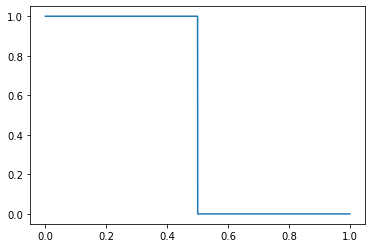

In [17]:
x = np.arange(step_signal.size) / sr
plt.plot(x, step_signal)

## ideal peak detector

$$
\begin{aligned}
y_{L}[n]=& \alpha_{R} y_{L}[n-1] \\
&+\left(1-\alpha_{A}\right) \max \left(x_{L}[n]-y_{L}[n-1], 0\right)
\end{aligned}
$$

In [31]:
def ideal_peak_detector(x, fs, release_t, attack_t):
    release_coef = calcTimeCoefficient(release_t, fs)
    attack_coef = calcTimeCoefficient(attack_t, fs)
    
    y = np.zeros(x.size)
    y_pre = 0
    for i in range(x.size):
        y[i] = release_coef*y_pre + (1-attack_coef)*max(x[i]-y_pre, 0)
        y_pre = y[i]
        
    return y

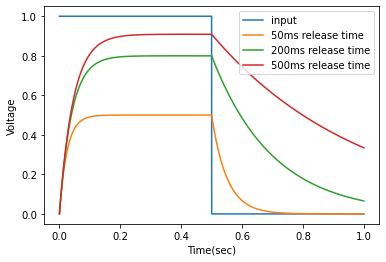

In [32]:
attack_time = 0.05
y0 = ideal_peak_detector(step_signal, fs, 0.05, attack_time)
y1 = ideal_peak_detector(step_signal, fs, 0.2, attack_time)
y2 = ideal_peak_detector(step_signal, fs, 0.5, attack_time)

x = np.arange(step_signal.size) / sr
plt.plot(x, step_signal, label='input')
plt.plot(x, y0, label='50ms release time')
plt.plot(x, y1, label='200ms release time')
plt.plot(x, y2, label='500ms release time')
plt.xlabel('Time(sec)')
plt.ylabel('Voltage')
plt.legend()
plt.show()

## decoupled peak detector
$$
\begin{array}{l}
y_{1}[n]=\max \left(x_{L}[n], \alpha_{R} y_{1}[n-1]\right) \\
y_{L}[n]=\alpha_{A} y_{L}[n-1]+\left(1-\alpha_{A}\right) y_{1}[n]
\end{array}
$$

In [42]:
def decoupled_peak_detector(x, fs, release_t, attack_t):
    release_coef = calcTimeCoefficient(release_t, fs)
    attack_coef = calcTimeCoefficient(attack_t, fs)
    
    y = np.zeros(x.size)
    y1_pre = 0
    y_pre = 0
    for i in range(x.size):
        y1 = max(x[i], release_coef*y1_pre)
        y[i] = attack_coef*y_pre + (1-attack_coef)*y1
        
        y1_pre = y1
        y_pre = y[i]
        
    return y

## branching peak detector
$$
y_{L}[n]=\left\{\begin{array}{ll}
\alpha_{A} y_{L}[n-1]+\left(1-\alpha_{A}\right) x_{L}[n] & x_{L}[n]>y_{L}[n-1] \\
\alpha_{R} y_{L}[n-1] & x_{L}[n] \leq y_{L}[n-1]
\end{array}\right.
$$

In [43]:
def branching_peak_detector(x, fs, release_t, attack_t):
    release_coef = calcTimeCoefficient(release_t, fs)
    attack_coef = calcTimeCoefficient(attack_t, fs)
    
    y = np.zeros(x.size)
    y_pre = 0
    for i in range(x.size):
        if x[i] > y_pre:
            y[i] = attack_coef*y_pre + (1-attack_coef)*x[i]
        else:
            y[i] = release_coef*y_pre
        
        y_pre = y[i]
        
    return y

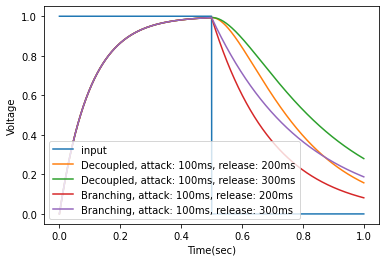

In [45]:
y_decoupled0 = decoupled_peak_detector(step_signal, fs, 0.2, 0.1)
y_decoupled1 = decoupled_peak_detector(step_signal, fs, 0.3, 0.1)
y_branching0 = branching_peak_detector(step_signal, fs, 0.2, 0.1)
y_branching1 = branching_peak_detector(step_signal, fs, 0.3, 0.1)

x = np.arange(step_signal.size) / sr
plt.plot(x, step_signal, label='input')
plt.plot(x, y_decoupled0, label='Decoupled, attack: 100ms, release: 200ms')
plt.plot(x, y_decoupled1, label='Decoupled, attack: 100ms, release: 300ms')
plt.plot(x, y_branching0, label='Branching, attack: 100ms, release: 200ms')
plt.plot(x, y_branching1, label='Branching, attack: 100ms, release: 300ms')
plt.xlabel('Time(sec)')
plt.ylabel('Voltage')
plt.legend()
plt.show()

## decoupled smooth peak detector
$$
\begin{array}{l}
y_{1}[n]=\max \left(x_{L}[n], \alpha_{R} y_{1}[n-1]+\left(1-\alpha_{R}\right) x_{L}[n]\right) \\
y_{L}[n]=\alpha_{A} y_{L}[n-1]+\left(1-\alpha_{A}\right) y_{1}[n]
\end{array}
$$


In [49]:
def decoupled_smooth_peak_detector(x, fs, release_t, attack_t):
    release_coef = calcTimeCoefficient(release_t, fs)
    attack_coef = calcTimeCoefficient(attack_t, fs)
    
    y = np.zeros(x.size)
    y1_pre = 0
    y_pre = 0
    for i in range(x.size):
        y1 = max(x[i], release_coef*y1_pre + (1-release_coef)*x[i])
        y[i] = attack_coef*y_pre + (1-attack_coef)*y1
        
        y1_pre = y1
        y_pre = y[i]
        
    return y

## branching smooth peak detector
$$
y_{L}[n]=\left\{\begin{array}{ll}
\alpha_{A} y_{L}[n-1]+\left(1-\alpha_{A}\right) x_{L}[n] & x_{L}[n]>y_{L}[n-1] \\
\alpha_{R} y_{L}[n-1]+\left(1-\alpha_{R}\right) x_{L}[n] & x_{L}[n] \leq y_{L}[n-1]
\end{array}\right.
$$

In [50]:
def branching_smooth_peak_detector(x, fs, release_t, attack_t):
    release_coef = calcTimeCoefficient(release_t, fs)
    attack_coef = calcTimeCoefficient(attack_t, fs)
    
    y = np.zeros(x.size)
    y_pre = 0
    for i in range(x.size):
        if x[i] > y_pre:
            y[i] = attack_coef*y_pre + (1-attack_coef)*x[i]
        else:
            y[i] = release_coef*y_pre + (1-release_coef)*x[i]
        
        y_pre = y[i]
        
    return y

In [54]:
def genetate_step_plateau_signal(fs):
    first_part_length = int(fs * 0.3);
    second_part_length = int(fs * 0.7)
    
    all_ones = np.ones(first_part_length)
    plateau_part = np.ones(second_part_length) * 0.25
    result = np.append(all_ones, plateau_part)
    
    return result;

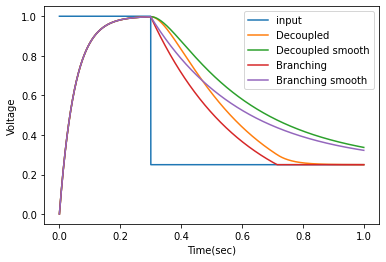

In [55]:
attack_time = 0.05
release_time = 0.3
step_plateau_signal = genetate_step_plateau_signal(fs)

y_decoupled = decoupled_peak_detector(step_plateau_signal, fs, release_time, attack_time)
y_decoupled_smooth = decoupled_smooth_peak_detector(step_plateau_signal, fs, release_time, attack_time)
y_branching = branching_peak_detector(step_plateau_signal, fs, release_time, attack_time)
y_branching_smooth = branching_smooth_peak_detector(step_plateau_signal, fs, release_time, attack_time)

x = np.arange(step_signal.size) / sr
plt.plot(x, step_plateau_signal, label='input')
plt.plot(x, y_decoupled, label='Decoupled')
plt.plot(x, y_decoupled_smooth, label='Decoupled smooth')
plt.plot(x, y_branching, label='Branching')
plt.plot(x, y_branching_smooth, label='Branching smooth')
plt.xlabel('Time(sec)')
plt.ylabel('Voltage')
plt.legend()
plt.show()